In [1]:
import cosmopower as cp
import frb_cov as frb
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load Emulators

In [2]:
bias_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/bias_sq_model")
power_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/pkmm_nonlin_model")


Define fiducial cosmology and initialise cosmo dictionary


In [3]:
sigma8 = 0.834  # fluctuation amplitude
h = 0.674       # Hubble constant
omegam = 0.3    # matter density parameter
omegab = 0.05   # baryon density parameter
omegade = 1.0 - omegam # DE density parameter
w0 = -1         # DE equation of state
wa = 0          # DE equation of state
ns = 0.963      # spectral index of primordial power spectrum
neff = 3.046    # effective number of relativistic degrees of freedom
mnu = 0         # Neutrino mass in eV
Tcmb0 = 2.725   
alpha_B = 0.1   # Horndeski braiding
alpha_M = 0.1   # Horndeski Planck mass running
log_TAGN = 7.8  # feedback parameter (Mead2020)
ks = 0.1        # screening scale for modified gravity
delta_gamma = 0. # is there EP breaking=?
keys = ['sigma_8', 'h', 'omega_m', 'omega_b', 'omega_de', 'w0', 'wa',
        'ns', 'neff', 'm_nu', 'Tcmb0', 'alpha_B', 'alpha_M', 'logTAGN', 'ks', 'delta_gamma']
values = [sigma8, h, omegam, omegab, omegade,
          w0, wa,  ns, neff, mnu, Tcmb0, alpha_B, alpha_M, log_TAGN, ks, delta_gamma]
cosmo = dict(zip(keys, values))

Prepare FRB SAMPLE and read from different catalogues.

In [4]:
file_paths = ['./../data/FRBCat_arXiv2307.03344.csv']
ra_labels = ['RA (FRB)', 'ra (deg)']
dec_labels = ['Dec (FRB)', 'dec (deg)']
redshift_labels = ['z (host)', 'redshift', 'z_gal']
DM_obs_labels = ['DM (pc/cm3)',"dm", 'DM_obs']
DM_MW_labels = ['DM_ISM',"dm_milky_way", 'DM_MW']

ra = [] # RA
dec = [] # DEC
zet = [] # redshift
DM_obs = [] # Observed DM
DM_MW = [] # MW DM
frb_id = [] # ID of FRB
for file_path in file_paths:
    df = pd.read_csv(file_path)
    for keys in ra_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                ra.append(i_aux)
        except:
            continue
    for keys in dec_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                dec.append(i_aux)
        except:
            continue
    for keys in DM_obs_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_obs.append(i_aux)
        except:
            continue
    for keys in redshift_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                zet.append(i_aux)
        except:
            continue
    for keys in DM_MW_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_MW.append(i_aux)
        except:
            continue
ra = np.array(ra)
dec = np.array(dec)
DM_obs = np.array(DM_obs)
DM_MW = np.array(DM_MW)
zet = np.array(zet)
for i_ra, val_ra in enumerate(ra):
    if ":" in val_ra:
        ra[i_ra] = coord.Angle(val_ra, unit=units.degree)
for i_dec, val_dec in enumerate(dec):
    if ":" in val_dec:
        dec[i_dec] = coord.Angle(val_dec, unit=units.degree)

# Convert angles
ra = coord.Angle(ra, unit=units.degree)
dec = coord.Angle(dec, unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian*np.pi
n_with_host = len(zet)
z = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]

#Compute pairwise distance on the sky between FRBs
delta_theta = np.zeros((n_with_host, n_with_host))
for i in range(n_with_host):
    for j in range(n_with_host):
        if (i != j):
            delta_theta[i, j] = np.arccos(np.sin(
                ra[i])*np.sin(ra[j]) + np.cos(ra[i])*np.cos(ra[j])*np.cos(dec[i] - dec[j]))


Construct the covariance passing the comsology, the electron bias and matter power spectrum emulator, the redshifts of the FRBs, their pairwise separation and for flatsky

Calculating FRB-Covariance
You are asking for the EP breaking term, 'delta_gamma != 0'.
Make sure that you specify the frequency width and frequency band (centra value of the frequency) of each FRB in GHz!
Specifically specify 'frequency_width = ' and 'frequency_band = ' as keyword arguments in the constructor of the covariance.
Both must be arrays of the same length as the number of FRBs.
I will proceed by assuming that all FRBs are observed at 1GHz with a bandwidth of 0.5GHz


100%|██████████| 11/11 [00:00<00:00, 60.88it/s]


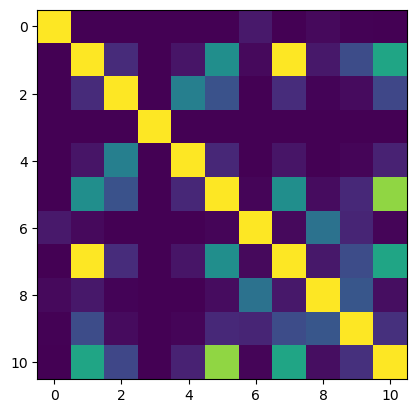

In [5]:
cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,flat_sky=True)
corr = cov.covariance/(np.diag(cov.covariance)[:, None]*np.diag(cov.covariance)[None, :])**.5
plt.imshow(corr)


Construct the covariance passing the comsology, the electron bias and matter power spectrum emulator, the redshifts of the FRBs, their pairwise separation and for curved sky.